# Developing a new prediction model 
    using Facebook's Prophet, an open source Python library 
<a id='docs'></a>
- Prophet Documentation: https://facebook.github.io/prophet/
- Pandas Documentation: https://pandas.pydata.org/
- Pandas TextBook: https://troweprice.sharepoint.com/:b:/r/sites/IntWorkPlanMgmt/Shared%20Documents/MSM%203.0/Python%20for%20Data%20Analysis.pdf?csf=1&web=1&e=04PfcZ
- Matplotlib Documentation: https://matplotlib.org/

## This Notebook will use pandas for data manipulation, matplotlib for data visualization, and Prophet for the prediction model.

The data being modeled is the daily call volume recieved from the RIS business unit, however these methods can be reused to make a prediction on any KPI of interest, for any business unit.

# Step 1: Load Data

In [152]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# create a pandas dataframe object
df = pd.read_csv('https://raw.githubusercontent.com/majickdave/dji_vol/master/dji.csv', 
                 header=1, 
                 usecols=[1,3,4], parse_dates=['Date'],
                index_col=['Date'], names=['Date', 'forecast', 'actual'])

df.head()

,forecast,actual
Date,,
2016-01-04,6547,6886
2016-01-05,4328,4928
2016-01-06,3987,3713
2016-01-07,4006,3910
2016-01-08,4107,3797


# What is the date range for the training data?
The available training data spans from January 1st, 2016 through August 13th, 2020

In [153]:
print('Start:', df.index.min())
print('End:', df.index.max())

Start: 2016-01-04 00:00:00
End: 2020-08-13 00:00:00


# How has the call volume changed over time?

The call volume appears to follow a general seasonal pattern with peaks at the beginning and end of the year, and a downward trend year over year.

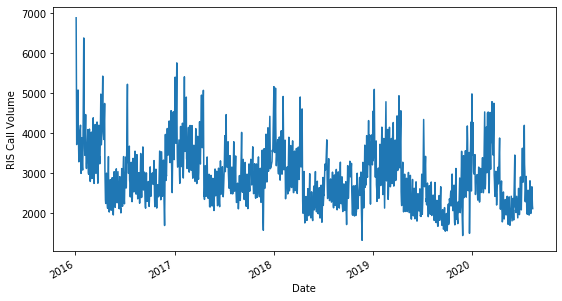

In [154]:
plt.figure(figsize=(9,5))
df['actual'].plot()
plt.ylabel('RIS Call Volume')
plt.show()

# Create Training Data and Fit Model
In order to train our model, we need to define a start and end date for the training data.
Typically, training should be performed with the most relevant or recent data.

In [155]:
# create a new dataframe with 2 columns, date and actual volume received
df['Date'] = df.index
df = df[['Date', 'actual']]

# Must pre-format column names
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2018-07-01']
df.head()

,ds,y
Date,,
2018-07-02,2018-07-02,2890
2018-07-03,2018-07-03,2190
2018-07-05,2018-07-05,2460
2018-07-06,2018-07-06,2440
2018-07-09,2018-07-09,3225


# Begin Training Model
Since this is the first model, only the default settings will be used. These settings, or hyperparameters can be tuned later, and will be a part the feature engineering of the model. Refer to the documentation at the [top of the page](#docs)

In [156]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

# Create future dates
This function allows us to create the future dates that we want to predict. We will start with creating the next hundred days after

In [157]:
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
627,2020-11-17
628,2020-11-18
629,2020-11-19
630,2020-11-20
631,2020-11-21


# Make Predicitons on future dates

In [158]:
future2 = future.copy()
future2 = future2[~future2['ds'].dt.weekday.isin([5,6])]
forecast = m.predict(future2)

In [159]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
598,2020-11-16,2850.800547,2365.211376,3352.240579
599,2020-11-17,2315.272323,1842.601612,2846.305315
600,2020-11-18,2128.655343,1638.622556,2565.903186
601,2020-11-19,2045.308447,1585.023472,2540.714857
602,2020-11-20,2141.718282,1633.099858,2638.206123


In [160]:
# query prediction for 
forecast[forecast['ds'] == '2020-10-23'][['ds','yhat']]

,ds,yhat
582,2020-10-23,2048.881943


# Look at most recent date and compare current forecast to prophet

Volume - RIS - October 23, 2020: 

| Date |  Forecast   |  Actual | Prophet |
| ---- | ---------- | -------- | ---------- |
|2020-10-23| 2195    | 1974    | 2049

As we can see, the prediction from prophet is much closer to actual volume in this specific instance.  This will vary across forecast dates, and as we train the model with more recent or relevant data we may see this accuracy increase, or, in the case of overfitting, decrease.  By controlling our training data in terms of date range, we can zero in on the best training data that will capture the most predictors in our model, raising the accuracy of our forecasts.

# Visualize seasonality and analyze trends.
The dark blue line is the prediction, the light blue line is the confidence interval, and the black dots is the actual volume. 

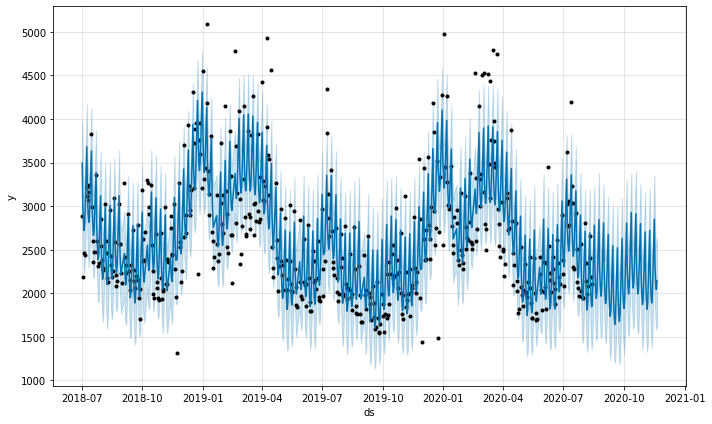

In [161]:
fig1 = m.plot(forecast)

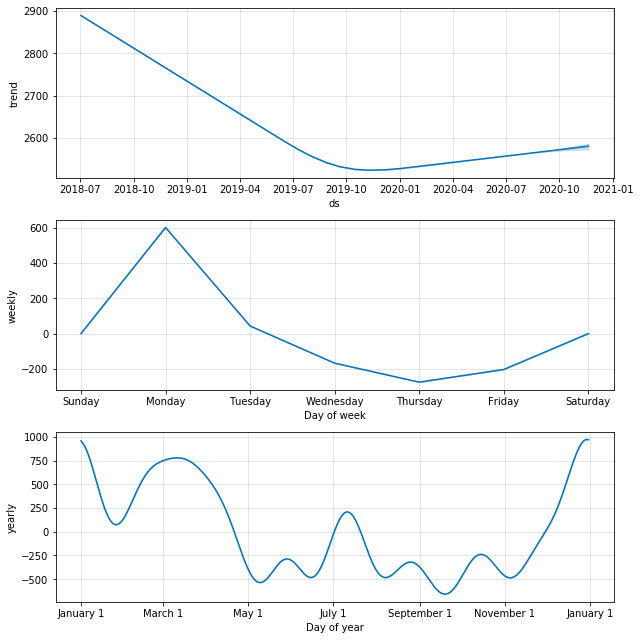

In [162]:
fig2 = m.plot_components(forecast)

# These three plots help visualize the seasonality that our model is capturing. 

<b>Trend</b>: The trend, as we noted previously is trending down towards 2020, and trending up through the year to the current date.

<b>Weekly</b>: Monday is a peak that trends down throughout the weekdays to Thursday, and begins to trend upwards on Friday.  Ignore Saturday and Sunday, there are actually no calls being serviced on the weekends.

<b>Yearly</b>: As noted previously, there is a peak at the beginning and end of the year with local maximums in March and less so in July.



# Calculate model performance metrics for original model and prophet 
Compare these 2 different forecasts to the actual volume from dates 2020-8-17 through 2020-10-13.

Only calls received will be considered.

In [163]:
# Load current volume and forecast
df2 = pd.read_csv('ris_forecast.csv', usecols=[0,1,2,3])
df2['date'] = pd.to_datetime(df2['date'])
df2.head()

,date,RECEIVED,FORECAST,HANDLED
0,2020-08-17,2404,2542,2274
1,2020-08-18,1922,2057,1764
2,2020-08-19,1926,1874,1779
3,2020-08-20,1769,1790,1724
4,2020-08-21,1933,1842,1643


In [164]:
# create forecast window
f = forecast[(forecast['ds']>='2020-08-17') & (
    forecast['ds']<'2020-10-14')][['ds','yhat', 'yhat_lower', 'yhat_upper']]

# get rid of weekends
f = f[~f['ds'].dt.weekday.isin([5,6])]

# drop the holiday labor day 2020
f = f[f['ds']!='2020-09-07']

In [165]:
def validate_dates(f, df2):
    """
    take in forecast, f
    and dataframe df2 and return Bool
    """
    res = []
    # validate forecast dates shape equals actual dates shape
    v1 = df2.shape[0] == f.shape[0]
    if not v1:
        return False
    else: res.append(v1)
        
    # validate all dates for forecast equal actual dates
    res.append(all(df2['date'].dt.date.values == f['ds'].dt.date.values))
    
    return all(res)

print(validate_dates(f, df2))

True


In [166]:
# join actual and current forecast to dataframe f
f['actual'] = df2['RECEIVED'].values

f['forecast'] = df2['FORECAST'].values

# Calculate Mean Absolute Percentage Error (MAPE)

In [117]:
def get_error(f, metric='MAPE'):
    """
    take in a dataframe f, of predictions, y_hat,
    and a list of actuals, y and return
    a float
    metric can be ['MAPE', 'RMSE']
    """
    res = {}
    # Do MAPE calc
    if metric == 'MAPE':
        res['prophet'] = ((f['actual']-f['yhat'])/f['actual']).abs().sum()/f.shape[0] * 100
        res['forecast'] = ((f['actual']-f['forecast'])/f['actual']).abs().sum()/f.shape[0] * 100
    # Do RMSE calc
    elif metric == 'RMSE':
        res['prophet'] = (((f['yhat']-f['actual'])**2).sum()/f.shape[0])**.5
        res['forecast'] = (((f['forecast']-f['actual'])**2).sum()/f.shape[0])**.5
    # TODO any other metric calc
    else:
        return 'There is an error with the metric'
    
    return pd.DataFrame(res, index=[metric])

mape, rmse = get_error(f), get_error(f, metric='RMSE')
display(mape)
# display(rmse)

# print(get_error(f, metric=1))

,prophet,forecast
MAPE,7.41866,8.212873


# Take a look at the 5 most recent predictions and compare to actual and forecasted volumes.

In [120]:
f['yhat'] = f['yhat'].round().astype(int)
f[['ds', 'yhat', 'actual', 'forecast']].tail()

,ds,yhat,actual,forecast
586,2020-10-07,2082,2014,2050
587,2020-10-08,1994,1971,1890
588,2020-10-09,2084,2240,1854
591,2020-10-12,2927,2678,2388
592,2020-10-13,2375,2617,2291


## The prophet model outperformed the current model on the MAPE metric by 0.8 percent.
MAPE is lower for the prophet model without any hyperparameter tuning, or feature engineering.

In [118]:
((mape['forecast'] - mape['prophet']).values[0]/100 * f['actual']).mean()

16.867727848135228

## Deploying this model for use in workforce planning could result in an average daily forecast accuracy improvement of 17 calls per day for RIS group. 

# Future Work

1. determine most important metric for forecasting in each business unit
    - tune hyperparameters of prophet model
    - work on analysis of forecasting
    - create different training, validation, and testing datasets (changing windows of time)

2. Create forecasts for handle time
    - repeat step 1

3. Create forecasts for other KPIs
    - repeat step 1
4. Test other time series models like ARIMA
5. Test Neural Networks (LSTM)
